# Spatial plots of tas/pr post Krakatoa eruption using CMIP6 historical model output
- opens all CMIP6 historical model run files with data on precipitation pr and surface temperature tas 
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- generates spatial plots at 4 discrete times following Krakatoa 1883 (Aug 1883, Feb 1884, Aug 1884, Aug 1885)

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
#import cmocean.cm as cmo # package with a nice colourbar for rainfall 

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [7]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out time around Krakatoa eruption

In [12]:
models = models.sel(time = slice('1850-01','1900-01'))

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [14]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

## Anomalies

In [15]:
# use functions to calculate the monthly anomalies for the globe and take the multi model mean 
K_mmm_mon_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01').mean(dim='model')

In [16]:
# select out regions for other anomalies 
K_mmm_mon_SH = K_mmm_mon_Glob.sel(lat=slice(-90,0)) 
K_mmm_mon_NH = K_mmm_mon_Glob.sel(lat=slice(0,90)) 
K_mmm_mon_Aus = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
K_mmm_mon_EA = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Figures

In [17]:
# eruption dates
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_post6mon = ['1884-02', '1903-04', '1963-09', '1982-10', '1991-12']
e_post12mon = ['1884-08','1903-10', '1964-03', '1983-04', '1992-06']
e_post24mon = ['1885-08','1904-10', '1965-03', '1984-04', '1993-06']

In [18]:
# dates and title for eruption and 3 times after
K_dates = [e_date[0], e_post6mon[0], e_post12mon[0], e_post24mon[0]]
title_label = ['Eruption month, ', '6 months post-eruption, ', '12 months post-eruption, ', '24 months post-eruption, ']

In [19]:
titles=[]
for i,vals in enumerate(K_dates):
    t = title_label[i] + K_dates[i]
    titles.append(t)
titles

['Eruption month, 1883-08',
 '6 months post-eruption, 1884-02',
 '12 months post-eruption, 1884-08',
 '24 months post-eruption, 1885-08']

In [21]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [20]:
# set the mod max for the colour bars
cmax_tas = 0.8
cmax_pr = 0.8

## need to figure out how to get rid of xlabels

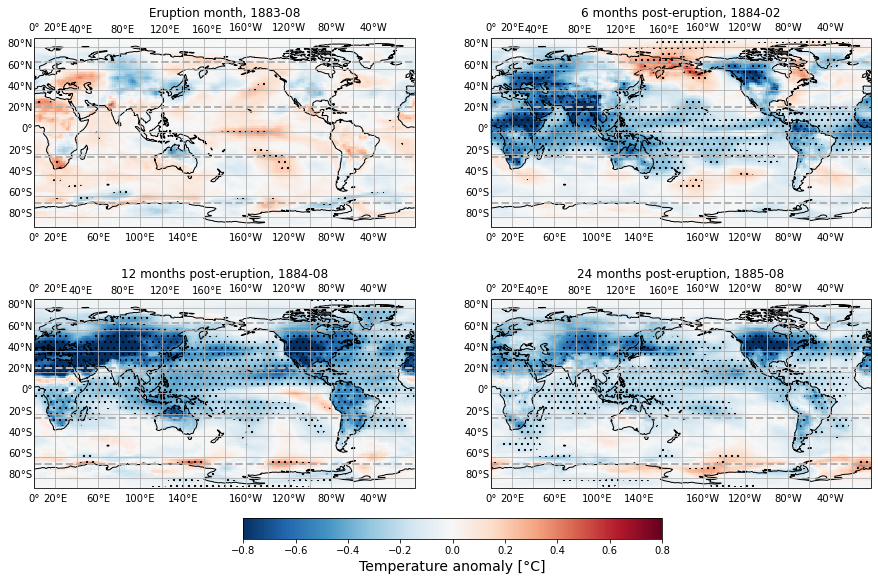

In [22]:
# plot of global monthly model mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

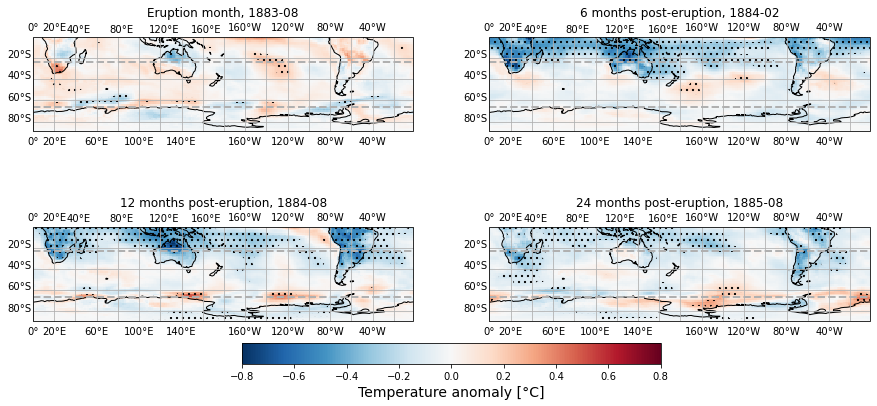

In [23]:
# plot of SH monthly model mean temperature
fig = fplot.spatial_plot(2, 2, K_mmm_mon_SH.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_SH.png', dpi=300)#, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


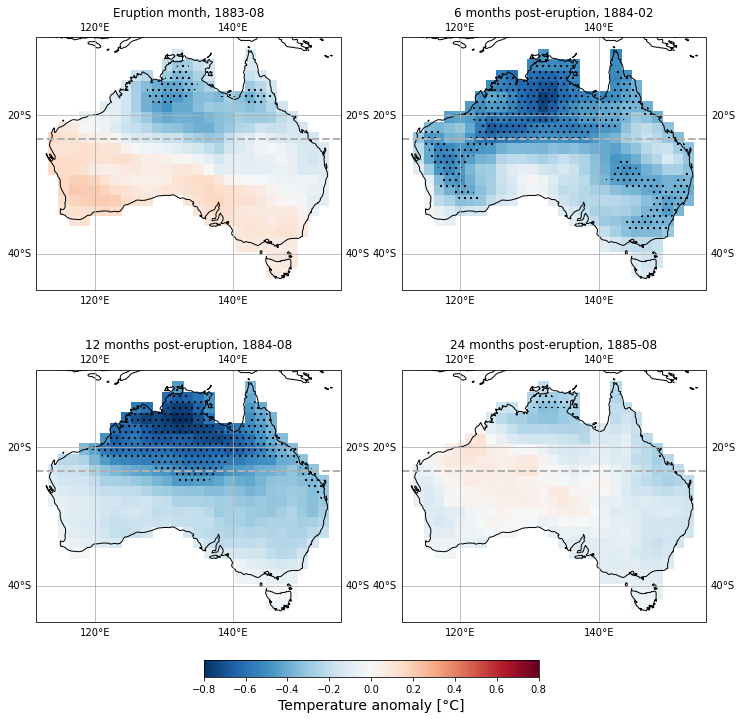

In [24]:
# plot of Aus monthly model mean temperature
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus.png', dpi=300, bbox_inches='tight')

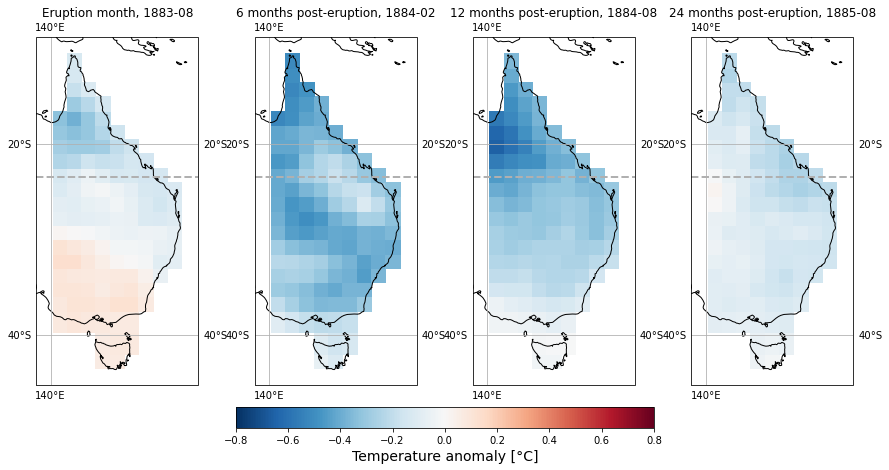

In [25]:
# plot of EA monthly model mean temperature
fig = fplot.spatial_plot(1, 4, K_mmm_mon_EA.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_EA.png', dpi=300, bbox_inches='tight')

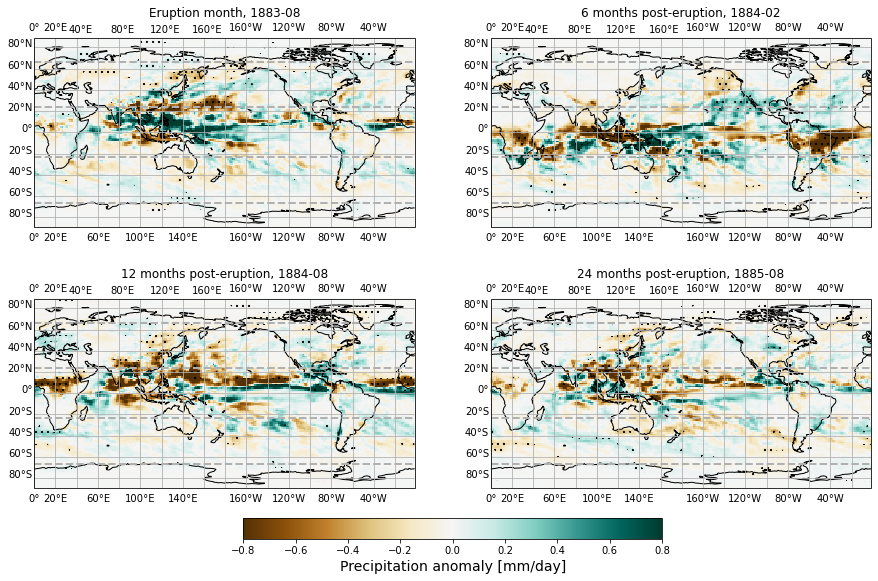

In [26]:
# plot of global monthly model mean precipitation
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob.png', dpi=300)#, bbox_inches='tight')

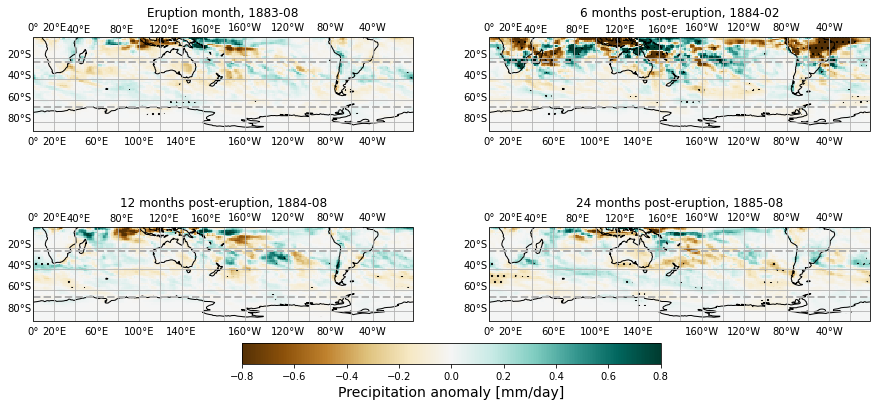

In [27]:
# plot of SH monthly model mean precipitation
fig = fplot.spatial_plot(2, 2, K_mmm_mon_SH.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_SH.png', dpi=300)#, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


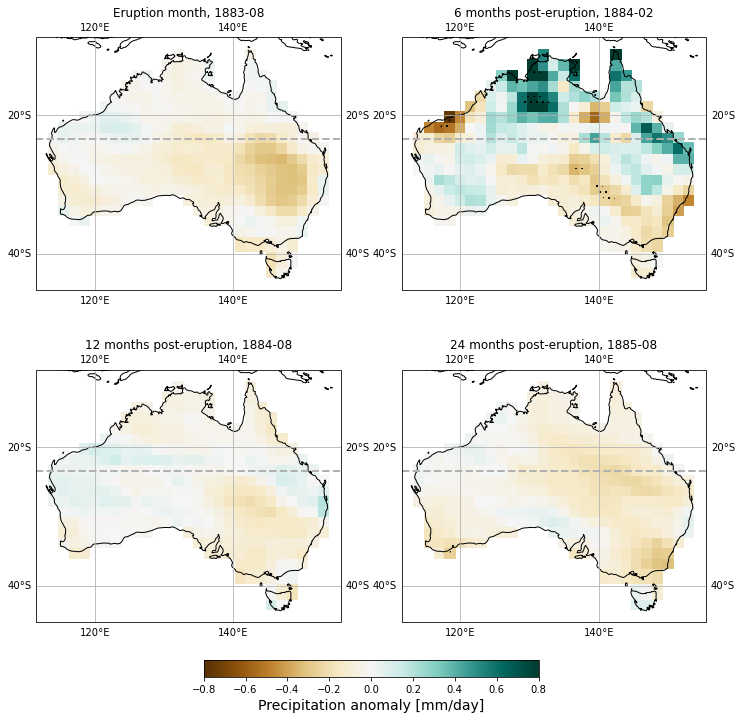

In [28]:
# plot of Aus monthly model mean precipitation
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus.png', dpi=300, bbox_inches='tight')

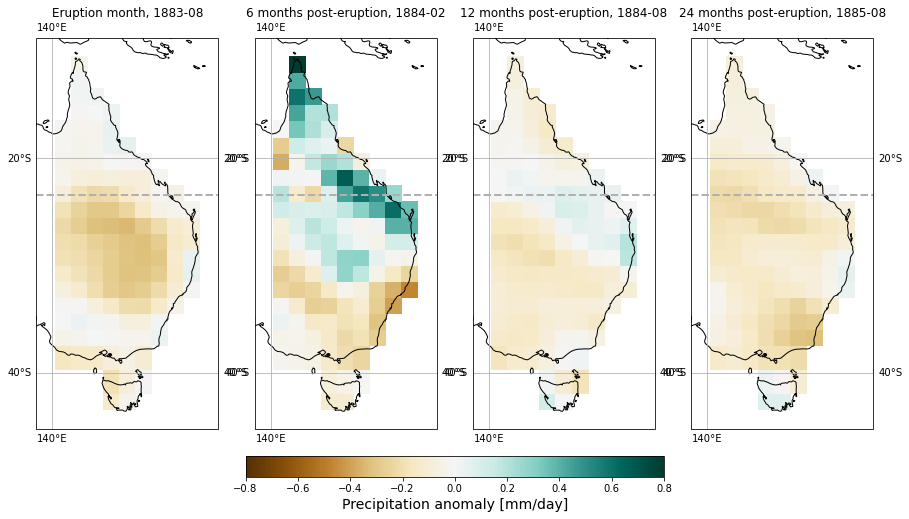

In [29]:
# plot of EA monthly model mean precipitation
fig = fplot.spatial_plot(1, 4, K_mmm_mon_EA.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(10) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_EA.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-39-34f7d6848c8a>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


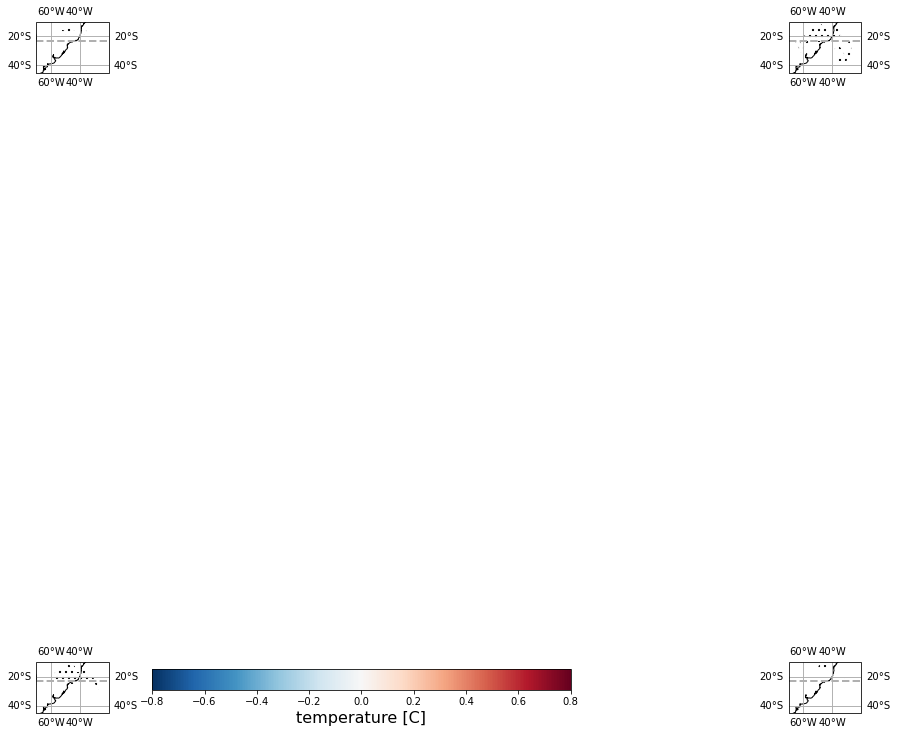

In [39]:
# use this to make any adjustments to my graphs

fig = plt.figure(figsize=(15,12))
axs = []

rows = 2
cols = 2
vmin = -0.8 #np.min(K_mmm_mon_Glob.pr).values
vmax = 0.8 #np.max(K_mmm_mon_Glob.pr).values

cmap = plt.get_cmap('RdBu_r')#, 15)

for i, d in enumerate(K_dates):    
    # Add a subplot with a projection    
    ax = fig.add_subplot(rows, cols, i+1, projection=ccrs.PlateCarree(180))        
    # Select the date and corresponding data and plot it    
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value    
    data = K_mmm_mon_Aus.tas.sel(time = K_dates[i])   
    C = data.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap)  
    # hatching
    data2 = sig_Aus.tas.sel(time = K_dates[i]).mean(dim='time')
    data2.plot.contourf(ax=ax, levels=[98, 1e10], hatches=[None,'..'], colors='none', add_colorbar=False)
    
    ax.coastlines()
    # add on grid lines for longitude and latitude at specified range and spacing
    ax.gridlines(xlocs=range(-180,181,20), ylocs=range(-80,81,20),draw_labels=False) 
    ax.gridlines(xlocs=range(-160,181,20), ylocs=range(-80,81,20),draw_labels=True)
    # add in different grid lines for tropics
    tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
    tropics.xlines=False
    #ax.set_title(titles[i])
    #ax.xaxis.label.set_visible(False)
    ax.set_ylabel([])
    ax.xaxis.set_visible(False)
    # set axis limits
#     ax.set_xlim(110, 160)
#     ax.set_ylim(-45, -10)
    ax.set(xlim=(110, 160), ylim=(-45, -10))
    # Gather all axes for when we make the colour bar    
    axs.append(ax)    
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('temperature [C]', fontsize=16)

fig.tight_layout()
